## Описание задачи
Исходная таблица с данными содержит значения погодных условий (испарение, температура, количество осадков за день, влажность, давление и т.д.), собранных с различных метеостанций Австралии, за 7 лет с (2007 по 2014 года), а также значения был ли дождь в этот день и был ли он завтра (значение, предсказание которого является задачей классификации для приведенного датасета).
## Чтение данных

In [1]:
from datetime import timedelta
import sklearn                  # Алгоритмы машинного обучения
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt  # Научная графика
%matplotlib inline
# Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне


Загружаем данные и после преобразовываем строковые значения *Yes* и *No* в признаках `RainToday` и `RainTomorrow` к **булевому** значению

In [2]:
path = "../datasets/weatherAUS.csv"
data_raw = pd.read_csv(path)
data_raw['RainToday'] = data_raw['RainToday'].apply(
    lambda v: None if type(v) == float else v == "Yes")
data_raw['RainTomorrow'] = data_raw['RainTomorrow'].apply(
    lambda v: None if type(v) == float else v == "Yes")


Преобразуем значения столбца `Date` из строкового типа к типу ***datetime***

In [3]:
data_raw['Date'] = pd.to_datetime(data_raw['Date'])
data_raw['Date'].dtype


dtype('<M8[ns]')

Количество строк и столбцов:

In [4]:
data_raw.shape

(145460, 23)

In [5]:
data_raw.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,False,False
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,False,False
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,False,False
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,False,False
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,False,False


Cтолбцы (признаки) имеют имена:

- `Date` - дата наблюдения
- `Location` - общепринятое название местоположения метеостанции
- `MinTemp` - минимальная температура в градусах Цельсия
- `MaxTemp` - максимальная температура в градусах Цельсия
- `Rainfall` - количество осадков, зафиксированных за день в мм
- `Evaporation` - испарение за 24 часа до 9:00
- `Sunshine` - количество часов яркого солнечного света в день
- `WindGustDir` - направление сильнейшего порыва ветра за 24 часа до полуночи
- `WindGustSpeed` - скорость (км/ч) самого сильного порыва ветра за 24 часа до полуночи
- `WindDir9am` - направление ветра в 9:00
- `WindDir3pm` - направление ветра в 15:00
- `WindSpeed9am` - средняя скорость ветра (км/ч) за 10 минут до 9:00
- `WindSpeed3pm` - средняя скорость ветра (км/ч) за 10 минут до 15:00
- `Humidity9am` - влажность (в процентах) в 9:00
- `Humidity3pm` - влажность (в процентах) в 15:00
- `Pressure9am` - атмосферное давление (гПа) относительно уровня моря в 9:00
- `Pressure3pm` - атмосферное давление (гПа) относительно уровня моря в 15:00
- `Cloud9am` - часть неба, закрытая облаками в 9:00. Это измеряется в октах, которые составляют восьмые доли. Она фиксирует, сколько восьмых частей неба закрыто облаками. Значение 0 указывает на полностью ясное небо, а значение 8 указывает на то, что оно полностью пасмурно.
- `Cloud3pm` - часть неба, закрытая облаками (в "октах", восьмые доли) в 15:00. Описание в `Cloud9am`
- `Temp9am` - температура (градусы цельсия) в 9:00
- `Temp3pm` - температура (градусы цельсия) в 15:00
- `RainToday` - логическое значение: 1, если количество осадков (мм) за 24 часа до 9 утра превышает 1 мм, в противном случае 0
- `RainTomorrow` - логическое значение: 1, если количество осадков (мм) за 24 часа следующего дня превышает 1 мм, в противном случае 0

У целевого признака (`RainTomorrow`) наблюдается несбалансированность классов: обьектов класса *0* больше, чем объектов класса *1*  

In [6]:
data_raw['RainTomorrow'].value_counts()


False    110316
True      31877
Name: RainTomorrow, dtype: int64

Признаки `RainToday`, `RainTomorrow` - бинарные, `Location`, `WindGustDir`, `WindDir9am`, `WindDir3pm` - номинальные (категориальные), остальные признаки - количественный (числовой).
Заменим типы категориальных признаков с ***'object'*** на специальный предназначенный для хранения категориальных значений:

In [7]:
data_raw['Location'] = data_raw['Location'].astype('category')
data_raw['Location'].dtype

CategoricalDtype(categories=['Adelaide', 'Albany', 'Albury', 'AliceSprings',
                  'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns',
                  'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin',
                  'GoldCoast', 'Hobart', 'Katherine', 'Launceston',
                  'Melbourne', 'MelbourneAirport', 'Mildura', 'Moree',
                  'MountGambier', 'MountGinini', 'Newcastle', 'Nhil',
                  'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
                  'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond',
                  'Sale', 'SalmonGums', 'Sydney', 'SydneyAirport',
                  'Townsville', 'Tuggeranong', 'Uluru', 'WaggaWagga',
                  'Walpole', 'Watsonia', 'Williamtown', 'Witchcliffe',
                  'Wollongong', 'Woomera'],
, ordered=False)

In [8]:
data_raw['WindGustDir'] = data_raw['WindGustDir'].astype('category')
data_raw['WindGustDir'].dtype


CategoricalDtype(categories=['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE',
                  'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'],
, ordered=False)

In [9]:
data_raw['WindDir9am'] = data_raw['WindDir9am'].astype('category')
data_raw['WindDir9am'].dtype

CategoricalDtype(categories=['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE',
                  'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'],
, ordered=False)

In [10]:
data_raw['WindDir3pm'] = data_raw['WindDir3pm'].astype('category')
data_raw['WindDir3pm'].dtype

CategoricalDtype(categories=['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE',
                  'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'],
, ordered=False)

## Визуалиция данных и вычисление основных характеристик

Построим графики для двух зависимых признаков

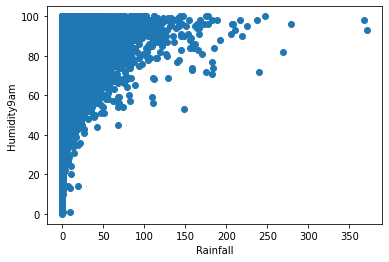

In [11]:
plt.scatter(data_raw['Rainfall'], data_raw['Humidity9am'], alpha=1)
plt.xlabel('Rainfall')
plt.ylabel('Humidity9am')
pass


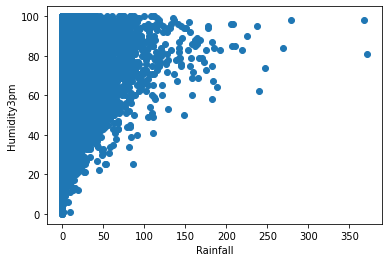

In [12]:
plt.scatter(data_raw['Rainfall'], data_raw['Humidity3pm'], alpha=1)
plt.xlabel('Rainfall')
plt.ylabel('Humidity3pm')
pass


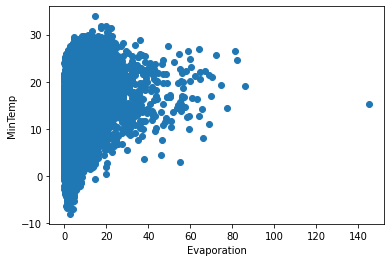

In [13]:
plt.scatter(data_raw['Evaporation'], data_raw['MinTemp'], alpha=1)
plt.xlabel('Evaporation')
plt.ylabel('MinTemp')
pass


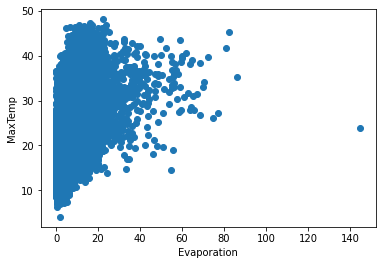

In [14]:
plt.scatter(data_raw['Evaporation'], data_raw['MaxTemp'], alpha=1)
plt.xlabel('Evaporation')
plt.ylabel('MaxTemp')
pass


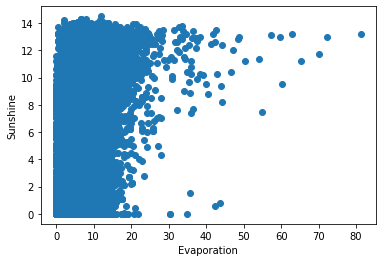

In [15]:
plt.scatter(data_raw['Evaporation'], data_raw['Sunshine'], alpha=1)
plt.xlabel('Evaporation')
plt.ylabel('Sunshine')
pass


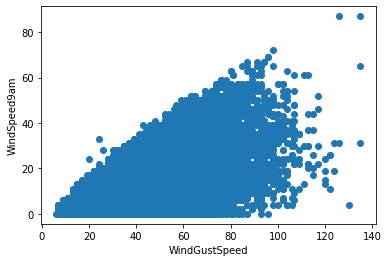

In [16]:
plt.scatter(data_raw['WindGustSpeed'], data_raw['WindSpeed9am'], alpha=1)
plt.xlabel('WindGustSpeed')
plt.ylabel('WindSpeed9am')
pass


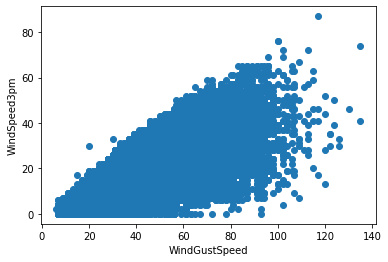

In [17]:
plt.scatter(data_raw['WindGustSpeed'], data_raw['WindSpeed3pm'], alpha=1)
plt.xlabel('WindGustSpeed')
plt.ylabel('WindSpeed3pm')
pass


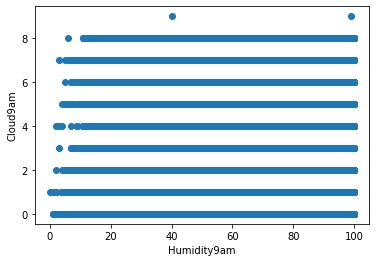

In [18]:
plt.scatter(data_raw['Humidity9am'], data_raw['Cloud9am'], alpha=1)
plt.xlabel('Humidity9am')
plt.ylabel('Cloud9am')
pass


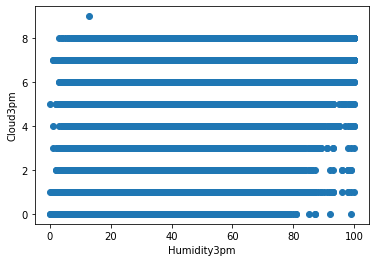

In [19]:
plt.scatter(data_raw['Humidity3pm'], data_raw['Cloud3pm'], alpha=1)
plt.xlabel('Humidity3pm')
plt.ylabel('Cloud3pm')
pass


Из графиков видно, что признаки `Cloud3pm` и `Cloud9am` принимают значение от 0 до 9. Значение равное 9 это выброс (значение этих признаков изменяются от 0 до 8). У признаков `Rainfall`, `Evaporation` и `WindGustSpeed` есть значения, которые сильно отличаются от признаков основной массы объектов.
Для обнаружения выборосов рассмотрим квантили для этих признаков.

In [20]:
data_raw['Cloud9am'].quantile([.1,.5,.70, .90, .95, 1])

0.10    1.0
0.50    5.0
0.70    7.0
0.90    8.0
0.95    8.0
1.00    9.0
Name: Cloud9am, dtype: float64

Для признака `Cloud9am` уберем все значения, которые превышают значения квантиля равное 0.9. Для признака `Cloud3pm` аналогично

In [21]:
data_raw['Rainfall'].quantile([.05, .1, .5, .9, .95, .99, .995,.998,.999, 1])


0.050      0.0
0.100      0.0
0.500      0.0
0.900      6.2
0.950     13.0
0.990     37.4
0.995     53.0
0.998     79.2
0.999    102.0
1.000    371.0
Name: Rainfall, dtype: float64

Для признака `Rainfall` уберем все значения, значений квантиля которых больше 0.999

In [22]:
data_raw['Evaporation'].quantile([.05, .1, .5, .9, .95, .99, .995, .998, .999, 1])


0.050      1.0000
0.100      1.4000
0.500      4.8000
0.900     10.2000
0.950     12.0000
0.990     18.4000
0.995     23.0000
0.998     33.5324
0.999     42.4662
1.000    145.0000
Name: Evaporation, dtype: float64

In [23]:
data_raw['WindGustSpeed'].quantile(
    [.05, .1, .5, .9, .95, .99, .995, .998, .999, 1])


0.050     20.0
0.100     24.0
0.500     39.0
0.900     57.0
0.950     65.0
0.990     81.0
0.995     87.0
0.998     94.0
0.999    100.0
1.000    135.0
Name: WindGustSpeed, dtype: float64

Соответсвенно для признаков `Evaporation` и `WindGustSpeed` аналогично как и для `Rainfall`

In [24]:
rows_to_drop = data_raw[
    (data_raw['Cloud9am'] == data_raw['Cloud9am'].quantile(1)) | (data_raw['Cloud3pm'] == data_raw['Cloud3pm'].quantile(1)) | (data_raw['Rainfall'] > data_raw['Rainfall'].quantile(0.999)) | (data_raw['Evaporation'] > data_raw['Evaporation'].quantile(0.999)) | (data_raw['WindGustSpeed'] > data_raw['WindGustSpeed'].quantile(0.999))].index
data = data_raw.drop(rows_to_drop)
data.shape

(145114, 23)

In [25]:
data.describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143632.000000,143855.000000,141856.000000,82488.000000,75445.000000,134861.000000,143353.000000,142058.000000,142469.000000,140620.000000,130069.000000,130107.000000,89317.000000,85851.000000,143351.000000,141513.000000
mean,12.183848,23.215642,2.217314,5.416176,7.618526,39.956348,14.018444,18.640816,68.881097,51.523332,1017.669993,1015.275066,4.445156,4.506762,16.982574,21.678980
std,6.395376,7.115475,7.068215,3.846834,3.781495,13.440696,8.882455,8.777681,19.013097,20.769858,7.094443,7.026386,2.886198,2.719709,6.486823,6.933057
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,978.200000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.300000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,102.000000,42.400000,14.500000,100.000000,130.000000,83.000000,100.000000,100.000000,1041.000000,1039.600000,8.000000,8.000000,40.200000,46.700000


Метрические характеристики числовых признаков:
* count - число значений
* mean - среднее арифметическое
* std - стандратное отклонение
* min - минимальное значение
* 25% - пертвый квартили
* 50% - второй квартиль или медиана
* 75% - третий квартиль
* max - максимальное значние

In [26]:
data.describe(include=['category'])


,Location,WindGustDir,WindDir9am,WindDir3pm
count,145114,134798,134559,140893
unique,49,16,16,16
top,Canberra,W,N,SE
freq,3433,9882,11737,10819


Матрица корреляции для количественных признаков:

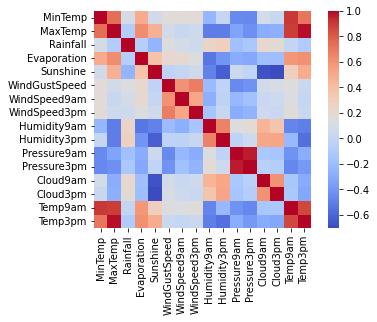

In [27]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass


Как видно из графика, есть признаки которые коррелируют между собой 

In [28]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)
               ).stack().sort_values(ascending=False)


MaxTemp        Temp3pm         0.984540
Pressure9am    Pressure3pm     0.961304
MinTemp        Temp9am         0.901753
MaxTemp        Temp9am         0.887181
Temp9am        Temp3pm         0.860585
MinTemp        MaxTemp         0.736471
               Temp3pm         0.708830
WindGustSpeed  WindSpeed3pm    0.686162
Humidity9am    Humidity3pm     0.666257
MaxTemp        Evaporation     0.625688
Evaporation    Temp3pm         0.609953
WindGustSpeed  WindSpeed9am    0.604891
Cloud9am       Cloud3pm        0.602925
Evaporation    Temp9am         0.583413
Humidity3pm    Cloud3pm        0.522193
WindSpeed9am   WindSpeed3pm    0.518042
Humidity3pm    Cloud9am        0.516048
dtype: float64

Посмотрим графики после преобразования данных

In [29]:
np.random.seed(42)
random_sub = np.random.choice(
    np.arange(data.shape[0]), size=5000, replace=False)


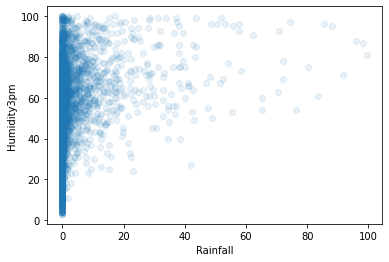

In [30]:
plt.scatter(data.iloc[random_sub]['Rainfall'],
            data.iloc[random_sub]['Humidity3pm'], alpha=0.1)
plt.xlabel('Rainfall')
plt.ylabel('Humidity3pm')
pass


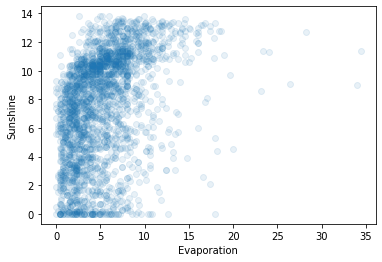

In [31]:
plt.scatter(data.iloc[random_sub]['Evaporation'],
            data.iloc[random_sub]['Sunshine'], alpha=0.1)
plt.xlabel('Evaporation')
plt.ylabel('Sunshine')
pass


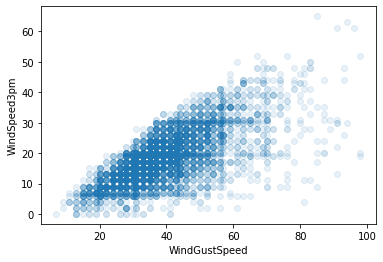

In [32]:
plt.scatter(data.iloc[random_sub]['WindGustSpeed'],
            data.iloc[random_sub]['WindSpeed3pm'], alpha=0.1)
plt.xlabel('WindGustSpeed')
plt.ylabel('WindSpeed3pm')
pass


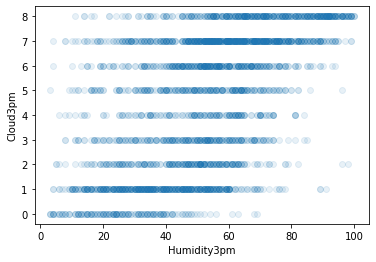

In [33]:
plt.scatter(data.iloc[random_sub]['Humidity3pm'],
            data.iloc[random_sub]['Cloud3pm'], alpha=0.1)
plt.xlabel('Humidity3pm')
plt.ylabel('Cloud3pm')
pass


## Обработка пропущенных значений

Определим признаки, которые содержат пропущенные значения

In [34]:
data.isna().sum()

Date                 0
Location             0
MinTemp           1482
MaxTemp           1259
Rainfall          3258
Evaporation      62626
Sunshine         69669
WindGustDir      10316
WindGustSpeed    10253
WindDir9am       10555
WindDir3pm        4221
WindSpeed9am      1761
WindSpeed3pm      3056
Humidity9am       2645
Humidity3pm       4494
Pressure9am      15045
Pressure3pm      15007
Cloud9am         55797
Cloud3pm         59263
Temp9am           1763
Temp3pm           3601
RainToday         3258
RainTomorrow      3262
dtype: int64

Пропущенныные значения для каждой количественной переменной заполняем их средним или медианным значением

In [35]:
columns = ["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm"]
data.fillna(data[columns].median(axis=0), axis=0, inplace=True)


In [36]:
data.isna().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation          0
Sunshine             0
WindGustDir      10316
WindGustSpeed        0
WindDir9am       10555
WindDir3pm        4221
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             0
Temp9am              0
Temp3pm              0
RainToday         3258
RainTomorrow      3262
dtype: int64

Для категориальных признаков пропущенные значения можно заполнить самым популярным значением в столбце:

In [37]:
data['WindGustDir'].fillna(data['WindGustDir'].mode().iloc[0], inplace=True)
data['WindDir9am'].fillna(data['WindDir9am'].mode().iloc[0], inplace=True)
data['WindDir3pm'].fillna(data['WindDir3pm'].mode().iloc[0], inplace=True)


Остались пропущенные значения только в целевом признаке и в `RainToday`

In [38]:
data.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday        3258
RainTomorrow     3262
dtype: int64

Удалим строки, в которых признаки `RainTomorrow` и `RainToday` имеют пропущенные значения, так как столбец `RainTomorrow` целевой, при этом неясно, как заполнить пропущенные значения `RainToday`

In [39]:
data.dropna(axis=0, how='all', subset=['RainTomorrow'], inplace=True)
data.dropna(axis=0, how='all', subset=['RainToday'], inplace=True)

In [40]:
data.isna().sum()


Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [41]:
data.describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000,140448.000000
mean,12.174054,23.228099,2.205980,5.157692,7.999496,39.834508,13.958276,18.616492,68.839706,51.448009,1017.667429,1015.279443,4.642515,4.697020,16.977867,21.677820
std,6.390299,7.103332,7.048667,2.934446,2.764822,12.974799,8.820489,8.686798,18.944766,20.521337,6.737299,6.671699,2.299620,2.122778,6.479128,6.869793
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,978.200000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,4.000000,8.200000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.500000,1011.000000,3.000000,4.000000,12.300000,16.700000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.300000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.600000,5.400000,8.800000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.300000
max,33.900000,48.100000,102.000000,42.400000,14.500000,100.000000,130.000000,83.000000,100.000000,100.000000,1041.000000,1039.600000,8.000000,8.000000,40.200000,46.700000


In [42]:
data.describe(include=['category'])


,Location,WindGustDir,WindDir9am,WindDir3pm
count,140448,140448,140448,140448
unique,49,16,16,16
top,Canberra,W,N,SE
freq,3399,18816,20897,14223


Преобразуем столбцы `RainTomorrow` и `RainToday` к числовому значению, пригодится для нормализации

In [43]:
data['RainTomorrow'] = data['RainTomorrow'].astype('float32')
data['RainToday'] = data['RainToday'].astype('float32')

## Обработка категориальных признаков

Бинаризуем категориальные признаки:

In [44]:
data = pd.get_dummies(data)
data.shape

(140448, 116)

In [45]:
data.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,2008-12-01,13.4,22.9,0.6,4.8,8.4,44.0,20.0,24.0,71.0,...,0,0,0,0,0,0,0,0,1,0
1,2008-12-02,7.4,25.1,0.0,4.8,8.4,44.0,4.0,22.0,44.0,...,0,0,0,0,0,0,0,0,0,1
2,2008-12-03,12.9,25.7,0.0,4.8,8.4,46.0,19.0,26.0,38.0,...,0,0,0,0,0,0,0,0,0,1
3,2008-12-04,9.2,28.0,0.0,4.8,8.4,24.0,11.0,9.0,45.0,...,0,0,0,0,0,0,0,0,0,0
4,2008-12-05,17.5,32.3,1.0,4.8,8.4,41.0,7.0,20.0,82.0,...,0,1,0,0,0,0,0,0,0,0


## Проведение нормализации

Выполним стандартизацию (линейное преобразование, приводящее все значения к нулевому среднему и единичному стандартному отклонению) всех признаков. Для этого удалим столбец с признаком `Data`, в дальнейшем он не пригодится

In [46]:
data_stand = data.drop(['Date'], axis=1)
np.random.seed(52)
random_subset = np.random.choice(
    np.arange(data_stand.shape[0]), size=40000, replace=False)
data_stand = data_stand.iloc[random_subset]
data_stand = (data_stand - data_stand.min(axis=0)) / \
    (data_stand.max(axis=0) - data_stand.min(axis=0))


Приведем признаки столбцов `RainTomorrow` и `RainToday` к исходному типу

In [47]:
data_stand['RainTomorrow'].astype('bool')
data_stand['RainToday'].astype('bool')
pass

In [48]:
data_stand.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000
mean,0.518441,0.542499,0.021644,0.126185,0.559178,0.359130,0.188402,0.285667,0.688035,0.513705,...,0.053125,0.060925,0.068850,0.101250,0.064325,0.056450,0.064325,0.068800,0.05965,0.064625
std,0.160503,0.137247,0.068888,0.071731,0.192911,0.137791,0.118505,0.133546,0.188547,0.204556,...,0.224286,0.239196,0.253202,0.301663,0.245334,0.230792,0.245334,0.253117,0.23684,0.245866
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.403509,0.441006,0.000000,0.098039,0.580420,0.265957,0.094595,0.200000,0.570000,0.370000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.513784,0.529981,0.000000,0.117647,0.587413,0.351064,0.175676,0.292308,0.700000,0.520000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.634085,0.640232,0.006863,0.132353,0.608392,0.425532,0.256757,0.369231,0.830000,0.650000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


## Разбиение данных на обучающие и тестовые

Проведем классификацию с помощью нескольких алгоритмов машинного обучения и сравним результаты. Для работы с моделями будут использоваться все выбранные признаки.

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [50]:
X = data_stand.drop(['RainTomorrow'], axis=1)
y = data_stand['RainTomorrow']

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=52)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test


(30000, 10000)

## Запуск классификатора KNN и вычисление ошибки на обучающей и тестовой выборке

Запустим классификатор KNN с параметром по умолчанию:

In [52]:
knn = KNeighborsClassifier()
knn.fit(X_train.values, y_train.values)
y_train_predict = knn.predict(X_train.values)
y_test_predict = knn.predict(X_test.values)
print("Train: {:.2f}%, Test: {:.2f}%".format(accuracy_score(
    y_train, y_train_predict) * 100, accuracy_score(y_test, y_test_predict) * 100))
print("MSE: Train {:.2f}, Test {:.2f}".format((mean_squared_error(y_train,
      y_train_predict)), mean_squared_error(y_test, y_test_predict)))


Train: 85.63%, Test: 80.21%
MSE: Train 0.14, Test 0.20


10 соседей

In [53]:
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_10.fit(X_train.values, y_train.values)
y_train_predict = knn_10.predict(X_train.values)
y_test_predict = knn_10.predict(X_test.values)
print("Train: {:.2f}%, Test: {:.2f}%".format(accuracy_score(
    y_train, y_train_predict) * 100, accuracy_score(y_test, y_test_predict) * 100))
print("MSE: Train {:.2f}, Test {:.2f}".format((mean_squared_error(y_train,
      y_train_predict)), mean_squared_error(y_test, y_test_predict)))


Train: 83.00%, Test: 80.45%
MSE: Train 0.17, Test 0.20


7 соседей

In [54]:
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_7.fit(X_train.values, y_train.values)
y_train_predict = knn_7.predict(X_train.values)
y_test_predict = knn_7.predict(X_test.values)
print("Train: {:.2f}%, Test: {:.2f}%".format(accuracy_score(
    y_train, y_train_predict) * 100, accuracy_score(y_test, y_test_predict) * 100))
print("MSE: Train {:.2f}, Test {:.2f}".format((mean_squared_error(y_train,
      y_train_predict)), mean_squared_error(y_test, y_test_predict)))


Train: 84.63%, Test: 80.48%
MSE: Train 0.15, Test 0.20


3 соседей

In [55]:
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train.values, y_train.values)
y_train_predict = knn_3.predict(X_train.values)
y_test_predict = knn_3.predict(X_test.values)
print("Train: {:.2f}%, Test: {:.2f}%".format(accuracy_score(
    y_train, y_train_predict) * 100, accuracy_score(y_test, y_test_predict) * 100))
print("MSE: Train {:.2f}, Test {:.2f}".format((mean_squared_error(y_train,
      y_train_predict)), mean_squared_error(y_test, y_test_predict)))


Train: 88.21%, Test: 79.17%
MSE: Train 0.12, Test 0.21


Как видно из результатов, при значениях **n_neighbors = 5, 7, 10** точность модели на тестовой выборке почти не отличается, а при **n_neighbors = 3** точность ухудшилась, но при этом же значении точность модели на тренировочной выборке лучше, чем на предыдущих

In [56]:
knn_15 = KNeighborsClassifier(n_neighbors=15)
knn_15.fit(X_train.values, y_train.values)
y_train_predict = knn_15.predict(X_train.values)
y_test_predict = knn_15.predict(X_test.values)
print("Train: {:.2f}%, Test: {:.2f}%".format(accuracy_score(
    y_train, y_train_predict) * 100, accuracy_score(y_test, y_test_predict) * 100))
print("MSE: Train {:.2f}, Test {:.2f}".format((mean_squared_error(y_train,
      y_train_predict)), mean_squared_error(y_test, y_test_predict)))


Train: 82.85%, Test: 80.71%
MSE: Train 0.17, Test 0.19


In [57]:
knn_20 = KNeighborsClassifier(n_neighbors=20)
knn_20.fit(X_train.values, y_train.values)
y_train_predict = knn_20.predict(X_train.values)
y_test_predict = knn_20.predict(X_test.values)
print("Train: {:.2f}%, Test: {:.2f}%".format(accuracy_score(
    y_train, y_train_predict) * 100, accuracy_score(y_test, y_test_predict) * 100))
print("MSE: Train {:.2f}, Test {:.2f}".format((mean_squared_error(y_train,
      y_train_predict)), mean_squared_error(y_test, y_test_predict)))


Train: 81.85%, Test: 80.33%
MSE: Train 0.18, Test 0.20


## Запуск других классификаторов. Сравнение результатов

### Random forest
Запустим классификатор Random forest с параметром по умолчанию:

In [58]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
print("Train: {:.2f}%, Test: {:.2f}%".format(accuracy_score(
    y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred) * 100))
print("MSE: Train {:.2f}, Test {:.2f}".format((mean_squared_error(y_train,
      y_train_pred)), mean_squared_error(y_test, y_test_pred)))


Train: 100.00%, Test: 85.21%
MSE: Train 0.00, Test 0.15


Запустим классификатор Random forest с **n_estimators=500**:

In [59]:
rf_model_500 = RandomForestClassifier(n_estimators=500)
rf_model_500.fit(X_train, y_train)
y_train_pred = rf_model_500.predict(X_train)
y_test_pred = rf_model_500.predict(X_test)
print("Train: {:.2f}%, Test: {:.2f}%".format(accuracy_score(
    y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred) * 100))
print("MSE: Train {:.2f}, Test {:.2f}".format((mean_squared_error(y_train,
      y_train_pred)), mean_squared_error(y_test, y_test_pred)))


Train: 100.00%, Test: 85.36%
MSE: Train 0.00, Test 0.15


При увеличении параметра **n_estimators**, точность модели незначительно увеличилась

In [60]:
pd.Series(rf_model_500.feature_importances_,
          index=X.columns).sort_values(ascending=False)


Humidity3pm              0.133328
Rainfall                 0.054066
Pressure3pm              0.053551
Sunshine                 0.051750
Humidity9am              0.051089
                           ...   
Location_Woomera         0.000832
Location_Townsville      0.000773
Location_AliceSprings    0.000714
Location_Katherine       0.000482
Location_Uluru           0.000397
Length: 114, dtype: float64

## Выводы

* Алгоритм ***KNN*** проигрывает алгоритму ***Random Forest*** по точности как на тестовой выборке, так и на обучающей
* В алгоритме ***KNN*** при увеличении значения числа соседей, точность модели не изменяется
* При увеличении числа решающих деревьев в алгоритме ***Random Forest***, точность алгоритма не изменилась